<a href="https://colab.research.google.com/github/liuxx479/NGphotoz/blob/master/prep_raytrace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
%matplotlib inline

In [216]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive/NGphotoz/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Photo-z code from MMR**

In [217]:
########### code from MMR

class PhotoZ_core(object):
    """Defines p(zp | z) of the core distribution (i.e. no outliers)
    """

    def __init__(self, zp_support, zbias, sigma_z):
        self.zp_support = zp_support
        self.zbias = zbias
        self.sigma_z = sigma_z

    def get_pdf_given(self, z):
        assert np.isscalar(z)
        rv = norm()
        scale = self.sigma_z * (1. + z)
        loc = z - self.zbias
        return rv.pdf((self.zp_support - loc) / scale) / scale


class PhotoZ_outlier(object):
    """ Define a gaussian distributed
    outlier population

    """
    def __init__(self, zp_support, z_cat, sigma_cat):
        self.z_cat = z_cat
        self.sigma_cat = sigma_cat
        self.zp_support = zp_support

    def get_pdf_given(self, z):
        assert np.isscalar(z)
        rv = norm()
        return rv.pdf((self.zp_support - self.z_cat) / self.sigma_cat) / self.sigma_cat


class PhotoZ_outlier_position(object):
    """ Define the position and fraction of
    the outlier populations for both the
    Lyman-Alpha and Balmer Breaks
    """
    def __init__(self, F_cat, delta_z_cat, z_cat_position):
        assert np.isscalar(F_cat)
        self.delta_z_cat = delta_z_cat
        self.z_cat_position = z_cat_position
        self.F_cat = F_cat

    def get_weight_given(self, z):
        assert np.isscalar(z)
        if (z > self.z_cat_position - self.delta_z_cat) and (z < self.z_cat_position + self.delta_z_cat):
            return self.F_cat
        else:
            return 0.


class LymanBalmerConfusion(object):
    """ We fix here the position of the
        Lyman-Balmer Confusion (maybe we need to adjust this)
        But this should be ok for now
    """
    def __init__(self, zp_support):
        self.outlier_pdf = PhotoZ_outlier(zp_support, z_cat=3.75, sigma_cat=0.25)

    def get_pdf_given(self, z):
        # Note this pdf is normalized to F_cat or zero!!!
        assert np.isscalar(z)
        outlier_pdf = self.outlier_pdf.get_pdf_given(z)
        return outlier_pdf


class LymanAlphaBalmerConfusion(object):
    """ We fix here the position of the
        LymanAlpha - Balmer Confusion (maybe we need to adjust this)
    """
    def __init__(self, zp_support):
        self.outlier_pdf = PhotoZ_outlier(zp_support, z_cat=0.5, sigma_cat=0.25)

    def get_pdf_given(self, z):
        # Note this pdf is normalized to F_cat or zero!!!
        assert np.isscalar(z)
        outlier_pdf = self.outlier_pdf.get_pdf_given(z)
        return outlier_pdf


class CoreAndOutlier(object):
    """
    Defines the core and outlier population

    """
    def __init__(self, zp_support, zbias, sigma_z, F_cat_lyman_balmer, F_cat_lyman_alpha_balmer):
        if sigma_z < 0.01:
            raise ValueError("Choosing a `close to delta' function as the conditional leads to numerical problems on a fixed grid!")
        self.zp_support = zp_support
        self.core = PhotoZ_core(zp_support, zbias, sigma_z)

        self.pos_lyman_balmer = PhotoZ_outlier_position(F_cat_lyman_balmer,
                                                        delta_z_cat=0.25, z_cat_position=0.25)
        self.lyman_balmer = LymanBalmerConfusion(zp_support)

        self.pos_lyman_alpha_balmer = PhotoZ_outlier_position(F_cat_lyman_alpha_balmer,
                                                              delta_z_cat=0.25, z_cat_position=3.)
        self.lyman_alpha_balmer = LymanAlphaBalmerConfusion(zp_support)

    def get_pdf_given(self, z):
        assert np.isscalar(z)
        weight_lyman_balmer = self.pos_lyman_balmer.get_weight_given(z)
        weight_lyman_alpha_balmer = self.pos_lyman_alpha_balmer.get_weight_given(z)
        weight_core = 1.0 - weight_lyman_balmer - weight_lyman_alpha_balmer
        # print(weight_core)
        core_pdf = self.core.get_pdf_given(z)
        core_pdf = core_pdf / np.trapz(core_pdf, self.zp_support)

        lyman_balmer_outliers = self.lyman_balmer.get_pdf_given(z)
        lyman_balmer_outliers = lyman_balmer_outliers / np.trapz(lyman_balmer_outliers, self.zp_support)

        lyman_alpha_balmer_outliers = self.lyman_alpha_balmer.get_pdf_given(z)
        lyman_alpha_balmer_outliers = lyman_alpha_balmer_outliers / np.trapz(lyman_alpha_balmer_outliers,
                                                                             self.zp_support)

        cond_pdf = weight_core * core_pdf + weight_lyman_balmer * lyman_balmer_outliers + weight_lyman_alpha_balmer * lyman_alpha_balmer_outliers
        return cond_pdf


class SmailZ(object):
    """ Define the True photometric redshift distribution
    that follows a Smail Type distribution
    """
    def __init__(self, z_support, z0, gamma, alpha):
        pdf = z_support ** alpha * np.exp(-(z_support / z0) ** (gamma))
        self.z_support = z_support
        self.pdf = pdf / np.trapz(pdf, z_support)

    def get_pdf(self):
        return self.pdf

    def get_pdf_convoled(self, filter_list):
        output_tomo_list = []
        for el in filter_list:
            output_tomo_list.append(el * self.pdf)
        output_tomo_list = np.array(output_tomo_list).T
        output_tomo_list = np.column_stack((self.z_support, output_tomo_list))
        return output_tomo_list


class PhotozModel(object):
    """Convolve the joint distribution p(z_s, z_p) with
    a set of filter functions (e.g. gaussian or tophat)

    The class function get_pdf produces an array of tomographic
    bins

    """
    def __init__(self, pdf_z, pdf_zphot_given_z, filters):
        self.pdf_zphot_given_z = pdf_zphot_given_z
        self.pdf_z = pdf_z
        self.filter_list = filters

    def normalize(self, pz):
        for i in range(pz.shape[1]):
            pz[:, i] = pz[:, i]/np.trapz(pz[:, i], self.pdf_zphot_given_z.zp_support)

        return pz

    def get_pdf(self):
        tomo_collect = []
        for el in self.filter_list:
            tomo_pdf = self.get_pdf_tomo(el)

            tomo_collect.append(tomo_pdf)

        tomo_collect = np.array(tomo_collect).T
        tomo_collect = self.normalize(tomo_collect)
        return tomo_collect

    def get_pdf_tomo(self, filter):
        z_support = self.pdf_z.z_support
        zp_support = self.pdf_zphot_given_z.zp_support
        z_pdf = self.pdf_z.get_pdf()
        pdf_joint = np.zeros((len(zp_support), len(z_support)))
        for i in range(len(z_support)):
            pdf_joint[:, i] = self.pdf_zphot_given_z.get_pdf_given(z_support[i]) * z_pdf[i] * filter[i]

        pdf_zp = np.zeros((len(zp_support),))
        for i in range(len(zp_support)):
            pdf_zp[i] = np.trapz(pdf_joint[i, :], z_support)

        return pdf_zp

**Test Joachim's Pz against LSST SB and SRD Pz**

In [247]:
######## Test Joachim's Pz against LSST SB/SRD Pz
######## SRD: https://arxiv.org/abs/1809.01669

def Pz_norm(zp_support, pz):
  return pz/np.trapz(pz, zp_support)

def Pz_norm_tomo(zp_support, pz):
  return array([Pz_norm(zp_support, ipz) for ipz in pz])

######### LSST SB Pz
Mlim = 25.3 ## gold sample
z0_SB = 0.0417*Mlim-0.744
Pz_SB = lambda z: Pz_norm(z, 0.5/z0_SB**3 * z**2 * exp(-z/z0_SB))
print ('SB',z0_SB, 1)

####### LSST SRD Y10 numbers page 53
z0_SRD, alpha_SRD = 0.11, 0.68
Pz_SRD = lambda z: Pz_norm(z, z**2 * exp(-(z/z0_SRD)**alpha_SRD))
print ('SRD',z0_SRD, alpha_SRD)

zarr=np.linspace(0,4, 501)

######## Joachim's Pz
Pz_JH = np.array([np.loadtxt(root+'pz_joachim/zdist_sources_bin%i.txt'%(i)) for i in range(5)])
zarr_JH = Pz_JH[0,:,0]
print (Pz_JH.shape)
Pz_JH_all = Pz_norm(zarr_JH, sum(Pz_JH[:,:,1], axis=0))

SB 0.31101 1
SRD 0.11 0.68
(5, 300, 2)


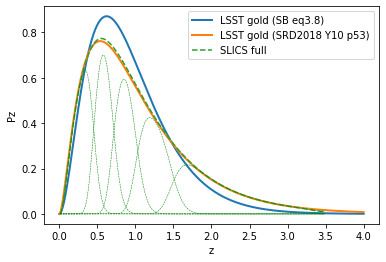

In [219]:
### plot
plot(zarr, Pz_SB(zarr), lw=2, label='LSST gold (SB eq3.8)')
plot(zarr, Pz_SRD(zarr), lw=2, label='LSST gold (SRD2018 Y10 p53)')
plot(zarr_JH, Pz_JH_all, '--', label='SLICS full')
for i in range(5):
  ipz = Pz_norm(zarr_JH, Pz_JH[i,:,1])
  plot(zarr_JH, ipz/5, 'g--', lw='0.5')#label='SLICS bin %i'%(i))
xlabel('z')
ylabel('Pz')
legend()
show()

**Test binning (equal width vs equal number)**
Choose equal width for now 

In [220]:
######### note
### pdf = z_support ** alpha * np.exp(-(z_support / z0) ** (gamma))
### LSST pdf = 1/(2z0)(z/z0)**2 exp(-z/z0), so alpha=2, gamma=1... note the gamma and alpha is reversed in MMR's definition
### pdf_z = SmailZ(z_support, z0=0.31101, gamma=1, alpha=2)

####### generate a Smail pdf class
pdf_z = SmailZ(zarr, z0=z0_SRD, gamma=alpha_SRD, alpha=2)

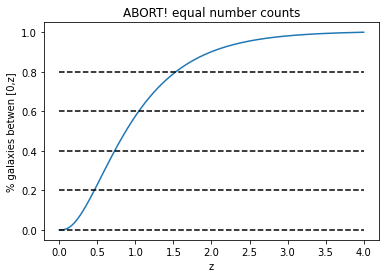

In [232]:
############ equal number count bins
Nfrac = array([np.trapz(pdf_z.get_pdf()[:i], zarr[:i]) for i in range(len(zarr))])
plot(zarr, Nfrac)
for i in range(5):
  plot(zarr, ones(len(zarr))*.2*i,'k--')
xlabel('z')
ylabel('% galaxies betwen [0,z]')
title('ABORT! equal number counts')
show()

In [259]:
############# equal width bins
###### as a better choice than equal number count bins: https://arxiv.org/pdf/1901.06495.pdf
tomo_centers=np.arange(0.5, 3, 0.5)
tomo_widths=np.ones(5)*0.5
tomo_bins = np.array([tomo_centers, tomo_widths]).T
# tomo_bins = np.array([[0.5, 0.5],
#                      [1.0, 0.5],
#                      [1.5, 0.5],
#                      [2.0, 0.5],
#                      [2.5, 0.5]])
# tomo_list = [norm.pdf(zarr, loc=x[0], scale=x[1]) for x in tomo_bins]
tomo_list = [uniform.pdf(zarr, loc=x[0]-x[1]/2.0, scale=x[1]) for x in tomo_bins]

def norm_tomo(ipdf):
  Ncounts = []
  bin_idx = []
  for i in range(5):
    z0, z1=tomo_centers[i]-0.25, tomo_centers[i]+0.25
    idx= where ((zarr<=z1) &(zarr>=z0))
    Ncounts.append(np.trapz(pdf_z.get_pdf()[idx], zarr[idx]))
    bin_idx.append([idx[0][0], idx[0][-1]])
  return bin_idx, Ncounts
  # print (Ncounts)

bin_idx, Ncounts = norm_tomo(pdf_z.get_pdf())
print (bin_idx)
print (Ncounts)

####### build the true tomo pdf
pdf_tomo = []
for i in range(5):
  x0, x1= bin_idx[i]
  ipdf=np.zeros(len(zarr))
  ipdf[x0:x1]=pdf_z.get_pdf()[x0:x1]
  pdf_tomo.append(ipdf)
pdf_tomo=np.array(pdf_tomo)
pdf_tomo.shape

[[32, 93], [94, 156], [157, 218], [219, 281], [282, 343]]
[0.3492425738897134, 0.27873658273108975, 0.15069475207340458, 0.0763559066251467, 0.03619438342192511]


(5, 501)

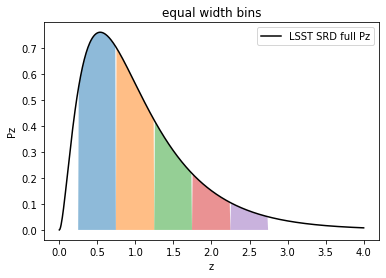

In [223]:
plot(zarr, pdf_z.get_pdf(),'k-', label='LSST SRD full Pz')
for i in range(5):
  fill_between(zarr, zeros(len(zarr)), pdf_tomo[i],alpha=0.5)
  # plot(zarr, pdf_zp[:, i]*Ncounts[i], '-', lw=1)#, label='z_center=%s'%(tomo_centers[i]))
legend()
xlabel('z')
ylabel('Pz')
title('equal width bins')
show()

**Apply Biases to Pz**

In [224]:
########### apply biases using MMR's code
def biased_pdf(pdf_z, zbias=0, sigma_z=0.02, out1=0.045, out2=0.045):
  coreandoutlier = CoreAndOutlier(zarr, zbias=zbias, sigma_z=sigma_z, 
                                F_cat_lyman_balmer=out1,
                                F_cat_lyman_alpha_balmer=out2)
  photoz_model = PhotozModel(pdf_z, coreandoutlier, tomo_list)
  pdf_z_biased = photoz_model.get_pdf()
  return pdf_z_biased

pdf_zp=biased_pdf(pdf_z, zbias=0, sigma_z=0.01, out1=0, out2=0)

###### to do: check outcome of tomo challenge, decide on binning

In [225]:
def plot_biased_pdf (pdf_zp,ilabel='equal number bins'):
  plot(zarr, pdf_z.get_pdf(),'k-', label='LSST SRD full Pz')
  for i in range(5):
    fill_between(zarr, zeros(len(zarr)), pdf_tomo[i],alpha=0.5)
    plot(zarr, pdf_zp[:, i]*Ncounts[i], '-', lw=2)
  legend()
  xlabel('z')
  ylabel('Pz')
  title(ilabel)
  show()

In [226]:
########## test plot, varying each of the 3 bias parameters one at a time #######

########## Bias parameters:
# Change the true LSST pz by:
# (1) zbias = 0.0003, 0.0007, 0.0015
# (2) sigma_z = 0.02, 0.04, 0.06
# (3) outlier fraction = 5%, 10%, 15%
########## Fiducial values:
# zbias=0.0007, sigma_z=0.02, outlier fraction 10%
# Other fixed parameter:
# F_cat_lyman_balmer=0.045, F_cat_lyman_alpha_balmer=0.045

pdf_arr = [biased_pdf(pdf_z, zbias=0.00, sigma_z=0.05, out1=0, out2=0), 
           biased_pdf(pdf_z, zbias=0.05, sigma_z=0.01, out1=0, out2=0),
           biased_pdf(pdf_z, zbias=0.00, sigma_z=0.01, out1=0.1, out2=0.1),]

**Test one bias parameter at a time**

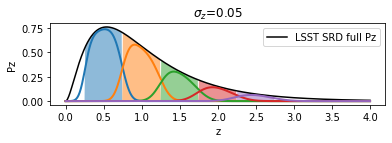

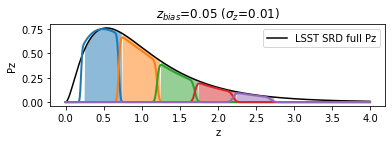

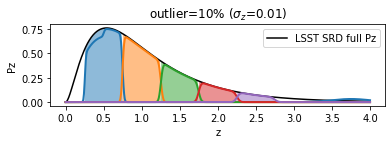

In [227]:
labels=['$\sigma_z$=0.05', '$z_{bias}$=0.05 ($\sigma_z$=0.01)', 'outlier=10% ($\sigma_z$=0.01)']

for i in range(3):
  figure(figsize=(6,1.5))
  plot_biased_pdf (pdf_arr[i],ilabel=labels[i])

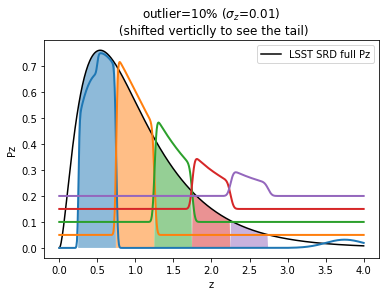

In [237]:
def plot_testoutlier (pdf_zp,ilabel='equal number bins'):
  plot(zarr, pdf_z.get_pdf(),'k-', label='LSST SRD full Pz')
  for i in range(5):
    fill_between(zarr, zeros(len(zarr)), pdf_tomo[i],alpha=0.5)
    plot(zarr, pdf_zp[:, i]*Ncounts[i]+i*0.05, '-', lw=2)
  legend()
  xlabel('z')
  ylabel('Pz')
  title(ilabel)
plot_testoutlier (pdf_arr[2],ilabel=labels[2]+"\n (shifted verticlly to see the tail)")

**Test multiple values per parameter**

In [229]:
############# plot out varying one parameter at a time, for multiple values #######
# (1) zbias = 0.0003, 0.0007, 0.0015
# (2) sigma_z = 0.02, 0.04, 0.06
# (3) outlier fraction = 5%, 10%, 15%

labels_zbias= ['$z_{bias}$=%s ($\sigma_z$=0.01)'%(izb) for izb in [0.0003, 0.0007, 0.0015]]
labels_sigmaz=['$\sigma_z$=%s'%(isz) for isz in [0.02, 0.04, 0.06]]
labels_out=['outlier=%s ($\sigma_z$=0.01)'%(iout) for iout in [0.05, 0.1, 0.15] ]

print(labels_zbias)
print(labels_out)
print(labels_sigmaz)

pdf_zbias = [biased_pdf(pdf_z, zbias=izbias, sigma_z=0.01, out1=0, out2=0) for izbias in [0.0003, 0.0007, 0.0015]]
pdf_sigmaz = [biased_pdf(pdf_z, zbias=0.00, sigma_z=isz, out1=0, out2=0) for isz in [0.02, 0.04, 0.06]]
pdf_out = [biased_pdf(pdf_z, zbias=0.00, sigma_z=0.01, out1=iout, out2=iout) for iout in [0.05, 0.1, 0.15]]

['$z_{bias}$=0.0003 ($\\sigma_z$=0.01)', '$z_{bias}$=0.0007 ($\\sigma_z$=0.01)', '$z_{bias}$=0.0015 ($\\sigma_z$=0.01)']
['outlier=0.05 ($\\sigma_z$=0.01)', 'outlier=0.1 ($\\sigma_z$=0.01)', 'outlier=0.15 ($\\sigma_z$=0.01)']
['$\\sigma_z$=0.02', '$\\sigma_z$=0.04', '$\\sigma_z$=0.06']


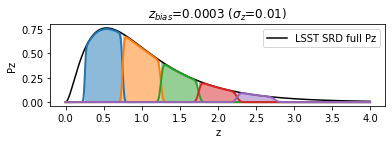

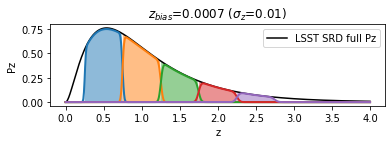

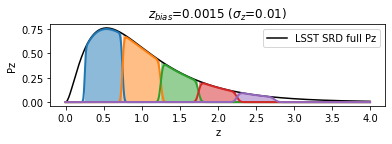

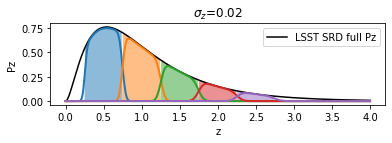

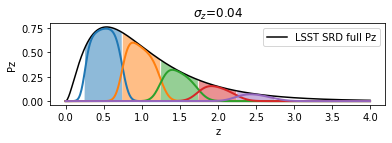

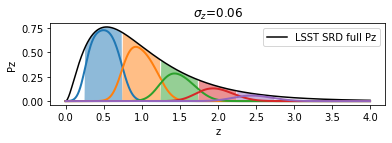

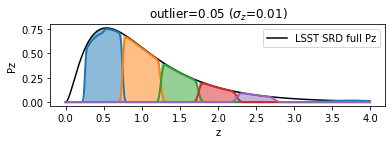

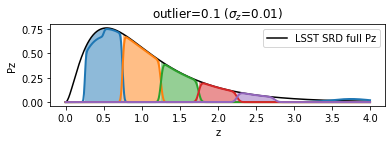

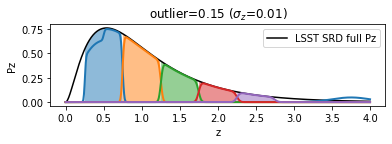

In [230]:
for i in range(3):
  for j in range(3):
    figure(figsize=(6,1.5))
    plot_biased_pdf ([pdf_zbias, pdf_sigmaz, pdf_out][i][j],ilabel=[labels_zbias, labels_sigmaz, labels_out][i][j])

**Mass production**

In [290]:
def plot_biased_pdf_both (pdf_zp, pdf_full, ilabel='test'):
  '''also save a file of the data vector'''
  plot(zarr, pdf_z.get_pdf(),'k-', lw=2, label='LSST SRD full Pz')
  plot(zarr, pdf_full,'r--', lw=1, label='Biased single bin')
  for i in range(5):
    fill_between(zarr, zeros(len(zarr)), pdf_tomo[i],alpha=0.5)
    plot(zarr, pdf_zp[:, i]*Ncounts[i], '-', lw=2)
  legend()
  xlabel('z')
  ylabel('Pz')
  title(ilabel)
  savefig(root+'plot_pz_SRD/fig_%s.jpg'%(ilabel))
  data_vector=concatenate([zarr.reshape(-1,1), pdf_full.reshape(-1,1), pdf_zp],axis=1)
  print (data_vector.shape)
  savetxt(root+'pz_SRD/pz_%s.txt'%(ilabel), data_vector, header='z full tomo0 tomo1 tomo2 tomo3 tomo4')
  close()

##### test
# plot_biased_pdf_both(pdf_z_biased, pdf_z_biased_full)

(501, 7)


In [265]:
zbias_arr = [0.0003, 0.0007, 0.0015]
sigmaz_arr = [0.01, 0.02, 0.04, 0.06]
out_arr = [0, 0.05, 0.1, 0.15]

## true full PDF
pdf_true = Pz_norm (zarr, pdf_z.get_pdf())
print (pdf_true.shape, np.trapz(pdf_true, zarr))

## true tomo PDF
pdf_tomo_normed = Pz_norm_tomo(zarr, pdf_tomo) ######## to be saved to file
print (pdf_tomo_normed.shape, np.trapz(pdf_tomo_normed, zarr))

## biased PDF
tophat_full = [uniform.pdf(zarr, loc=0, scale=4),] ### prepare for single redshift

def biased_pdf_both(pdf_z, zbias=0, sigma_z=0.02, out1=0.045, out2=0.045):
  coreandoutlier = CoreAndOutlier(zarr, zbias=zbias, sigma_z=sigma_z, 
                                F_cat_lyman_balmer=out1,
                                F_cat_lyman_alpha_balmer=out2)
  photoz_model = PhotozModel(pdf_z, coreandoutlier, tomo_list)
  pdf_z_biased = photoz_model.get_pdf()

  photoz_model_full = PhotozModel(pdf_z, coreandoutlier, tophat_full)
  pdf_z_biased_full = photoz_model_full.get_pdf()
  return pdf_z_biased, pdf_z_biased_full

# j=0
for izbias in zbias_arr:    
  for isz in sigmaz_arr:
    for iout in out_arr:
      # if j>0:
      #   break
      print (izbias, isz, iout)
      pdf_z_biased, pdf_z_biased_full=biased_pdf_both(pdf_z, zbias=izbias, sigma_z=isz, out1=iout, out2=iout)
      ilabel='zbias%s_simgaz%s_outlier%s'
      plot_biased_pdf_both(pdf_z_biased, pdf_z_biased_full,ilabel=ilabel)
      # j+=1


(501,) 1.0
(5, 501) [1. 1. 1. 1. 1.]
0.0003 0.01 0


In [268]:
pdf_z_biased.shape
pdf_z_biased_full.shape

(501, 1)

In [285]:
concatenate([zarr.reshape(-1,1), pdf_z_biased_full.reshape(-1,1), pdf_z_biased],axis=1).T.shape

(7, 501)